In [ ]:
import pandas as pd
file_path = "/content/NGAsub_MegaFlatfile_RotD50_050_R211022_public.xlsx"
df = pd.read_excel(file_path)

In [ ]:
df.rename(columns={
    'PGA_g': 'pga',
    'Earthquake_Magnitude': 'mag',
    'Rjb_km': 'rjb',
    'Hypocenter_Depth_km': 'hypd',
    'Vs30_Selected_for_Analysis_m_s': 'vs30',
    'Intra_Inter_Flag': 'intra_inter',
    'Sensor_Depth_m': 'sensor_depth',
    'Multiple_Event': 'multi_event',
    'Late_P_trigger_flag_1ptYes_0ptNo': 'late_flag',
    'Source_review_flag': 'src_flag',
    'Longest_Usable_Period_for_PSa_Ave_Component_sec': 'tgm',
    'NGAsubEQID': 'EqID',
    'Station_Name':'siteID'
}, inplace=True)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

# --- Load & Filter Dataset -
df = df[(df['pga'] != -999) & (df['pga'] <= 10) & (df['mag'] >= 4)]
meta_cols = ['mag', 'rjb', 'hypd', 'vs30',"Ztor_km"]
for col in meta_cols:
    df = df[df[col] != -999]
df = df[df['intra_inter'].isin([0, 1, 5])]
is_interface = (df['intra_inter'] == 0) & (df['hypd'] < 40)
is_intraslab = (df['intra_inter'] == 1) & (df['hypd'] < 200)
df = df[is_interface | is_intraslab]
df = df[(df['rjb'] <= 1000) & (df['sensor_depth'] <= 2)]
df = df[(df['multi_event'] != 1) & (df['late_flag'] != 1)]
df = df[df['src_flag'].isin([0, 1, 2, 4])]
df = df[df['tgm'] >= 10]
valid_eids = df['EqID'].value_counts()[lambda x: x >= 3].index
df = df[df['EqID'].isin(valid_eids)]

# --- Preprocessing ---
input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']
target_cols = [col for col in df.columns if col.startswith('T') and 'pt' in col]

df['rjb'] = df['rjb'].replace(0, 0.01)
df['vs30'] = df['vs30'].astype(float).replace(0, 0.01)
df['logrjb'] = np.log10(df['rjb'])
df['logvs30'] = np.log10(df['vs30'])

df[target_cols] = df[target_cols].clip(lower=1e-6)
df[target_cols] = np.log(df[target_cols])  # Natural log

df_clean = df.dropna(subset=input_cols + target_cols)

X = df_clean[input_cols].values
Y = df_clean[target_cols].values
EqIDs = df_clean['EqID'].values
siteIDs = df_clean['siteID'].values

scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# --- Splitting Data ---
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_scaled, Y_scaled, test_size=0.3, random_state=42, stratify=X_scaled[:, -1])
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=X_temp[:, -1])

# --- CVAE Definition ---
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 8  # Increased latent space

# Encoder
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling)([z_mean, z_log_var])
encoder = Model(inputs=input_layer, outputs=[z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(64, activation='relu')(latent_inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
output_layer = Dense(Y_train.shape[1], activation='linear')(x)
decoder = Model(inputs=latent_inputs, outputs=output_layer, name="decoder")

# Custom CVAE Model
class CVAE(Model):
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mse = MeanSquaredError()

    def compile(self, optimizer):
        super(CVAE, self).compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            rec_loss = self.mse(y, reconstruction)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = rec_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": rec_loss, "kl_loss": kl_loss}

    def test_step(self, data):
        x, y = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        rec_loss = self.mse(y, reconstruction)
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = rec_loss + kl_loss
        return {"loss": total_loss, "reconstruction_loss": rec_loss, "kl_loss": kl_loss}

# --- Training ---
cvae = CVAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cvae.compile(optimizer=optimizer)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = cvae.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# --- Evaluation ---
z_mean_test, _, _ = encoder.predict(X_test)
y_pred_scaled = decoder.predict(z_mean_test)

y_pred = scaler_Y.inverse_transform(y_pred_scaled)
Y_test_unscaled = scaler_Y.inverse_transform(Y_test)

r2 = r2_score(Y_test_unscaled, y_pred)
mse = mean_squared_error(Y_test_unscaled, y_pred)
print(f"\nR² Score on Test Set: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")


Epoch 1/150
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 0.1332 - loss: 0.5773 - reconstruction_loss: 0.4441 - val_kl_loss: 0.1525 - val_loss: 0.3646 - val_reconstruction_loss: 0.2121 - learning_rate: 0.0010
Epoch 2/150
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 0.1578 - loss: 0.4181 - reconstruction_loss: 0.2603 - val_kl_loss: 0.1550 - val_loss: 0.2030 - val_reconstruction_loss: 0.0480 - learning_rate: 0.0010
Epoch 3/150
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 0.1578 - loss: 0.4144 - reconstruction_loss: 0.2566 - val_kl_loss: 0.1534 - val_loss: 0.2504 - val_reconstruction_loss: 0.0969 - learning_rate: 0.0010
Epoch 4/150
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 0.1561 - loss: 0.4106 - reconstruction_loss: 0.2544 - val_kl_loss: 0.1389 - val_loss: 0.2758 - val_reconstruction_loss: 0.1370 - learning_rate: 0.0010
Epoch 5/150
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 0.1554 - loss: 0.4074 - reconstruction_loss: 0.2520 - val_kl_loss: 0.1593 - 

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


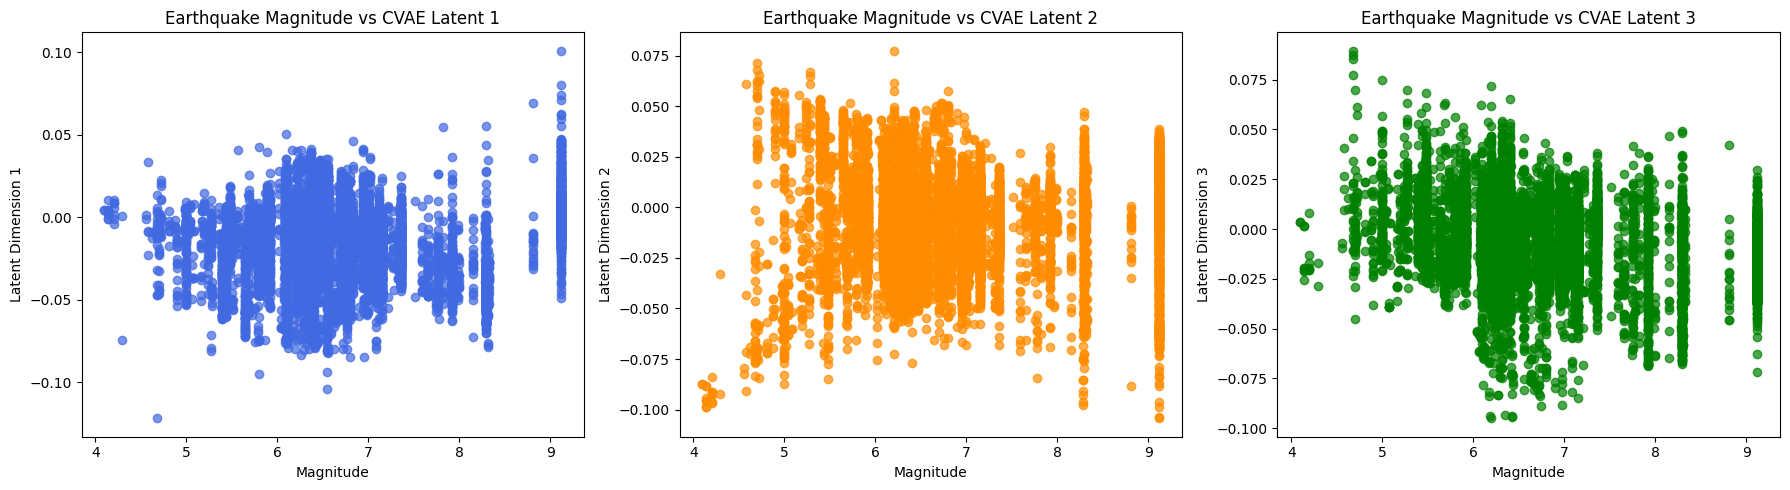

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Get Latent Space for Train Set ---
# Split df the same way as you did for train/test split earlier
df_train, df_temp = train_test_split(df_clean, test_size=0.3, random_state=42, stratify=df_clean['intra_inter'])
df_val, df_test_split = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['intra_inter'])

# Scale the input for train split
X_train_plot = scaler_X.transform(df_train[input_cols].values)

# Get z_mean (latent space) for train split
z_mean_train, _, _ = encoder.predict(X_train_plot)

# Extract magnitudes for plotting
magnitudes = df_train['mag'].values

# Pick first 3 latent components
latent1 = z_mean_train[:, 0]
latent2 = z_mean_train[:, 1]
latent3 = z_mean_train[:, 2]

# --- Plot ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(magnitudes, latent1, color='royalblue', alpha=0.7)
axs[0].set_title('Earthquake Magnitude vs CVAE Latent 1')
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('Latent Dimension 1')

axs[1].scatter(magnitudes, latent2, color='darkorange', alpha=0.7)
axs[1].set_title('Earthquake Magnitude vs CVAE Latent 2')
axs[1].set_xlabel('Magnitude')
axs[1].set_ylabel('Latent Dimension 2')

axs[2].scatter(magnitudes, latent3, color='green', alpha=0.7)
axs[2].set_title('Earthquake Magnitude vs CVAE Latent 3')
axs[2].set_xlabel('Magnitude')
axs[2].set_ylabel('Latent Dimension 3')

plt.tight_layout()
plt.show()


318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


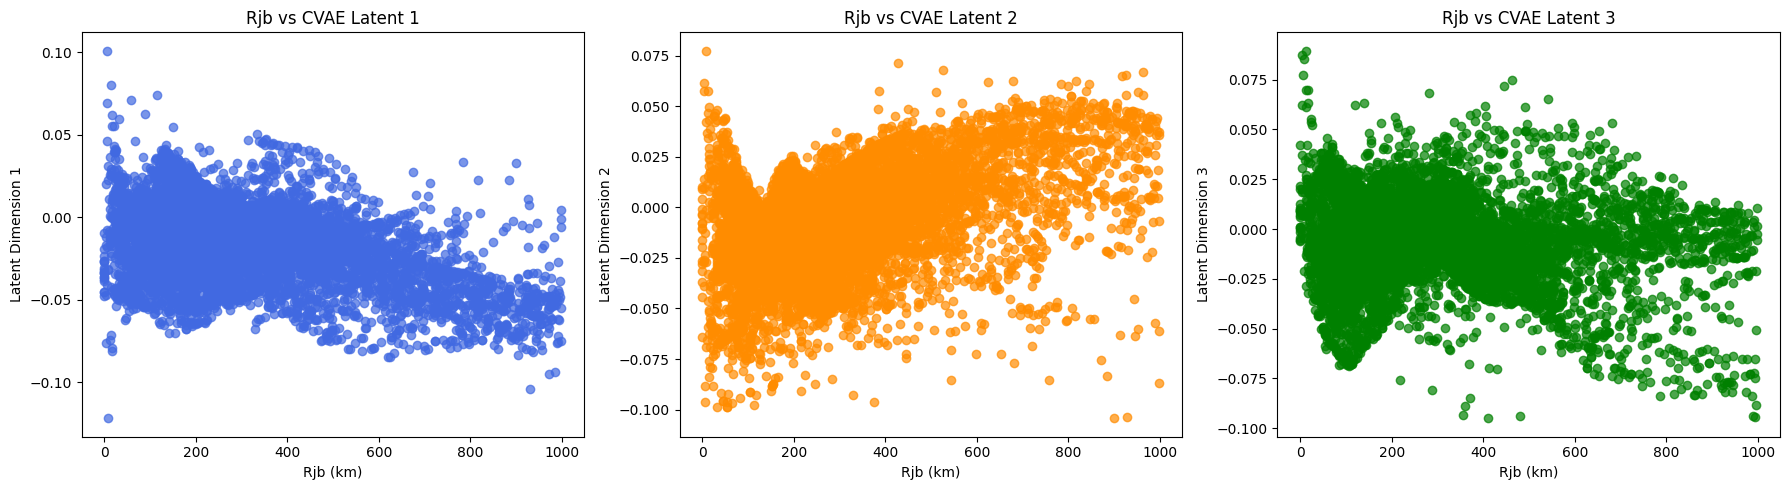

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# --- Get Latent Space for Train Set ---
# Split df_clean same way to get training rows
df_train, df_temp = train_test_split(df_clean, test_size=0.3, random_state=42, stratify=df_clean['intra_inter'])
df_val, df_test_split = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['intra_inter'])

# Extract Rjb values from train set
rjb = df_train['rjb'].values

# Scale the input columns
X_train_plot = scaler_X.transform(df_train[input_cols].values)

# Get z_mean (latent dimensions) from encoder
z_mean_train, _, _ = encoder.predict(X_train_plot)

# Extract first 3 latent components
latent1 = z_mean_train[:, 0]
latent2 = z_mean_train[:, 1]
latent3 = z_mean_train[:, 2]

# --- Plot ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(rjb, latent1, color='royalblue', alpha=0.7)
axs[0].set_title('Rjb vs CVAE Latent 1')
axs[0].set_xlabel('Rjb (km)')
axs[0].set_ylabel('Latent Dimension 1')

axs[1].scatter(rjb, latent2, color='darkorange', alpha=0.7)
axs[1].set_title('Rjb vs CVAE Latent 2')
axs[1].set_xlabel('Rjb (km)')
axs[1].set_ylabel('Latent Dimension 2')

axs[2].scatter(rjb, latent3, color='green', alpha=0.7)
axs[2].set_title('Rjb vs CVAE Latent 3')
axs[2].set_xlabel('Rjb (km)')
axs[2].set_ylabel('Latent Dimension 3')

plt.tight_layout()
plt.show()


318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


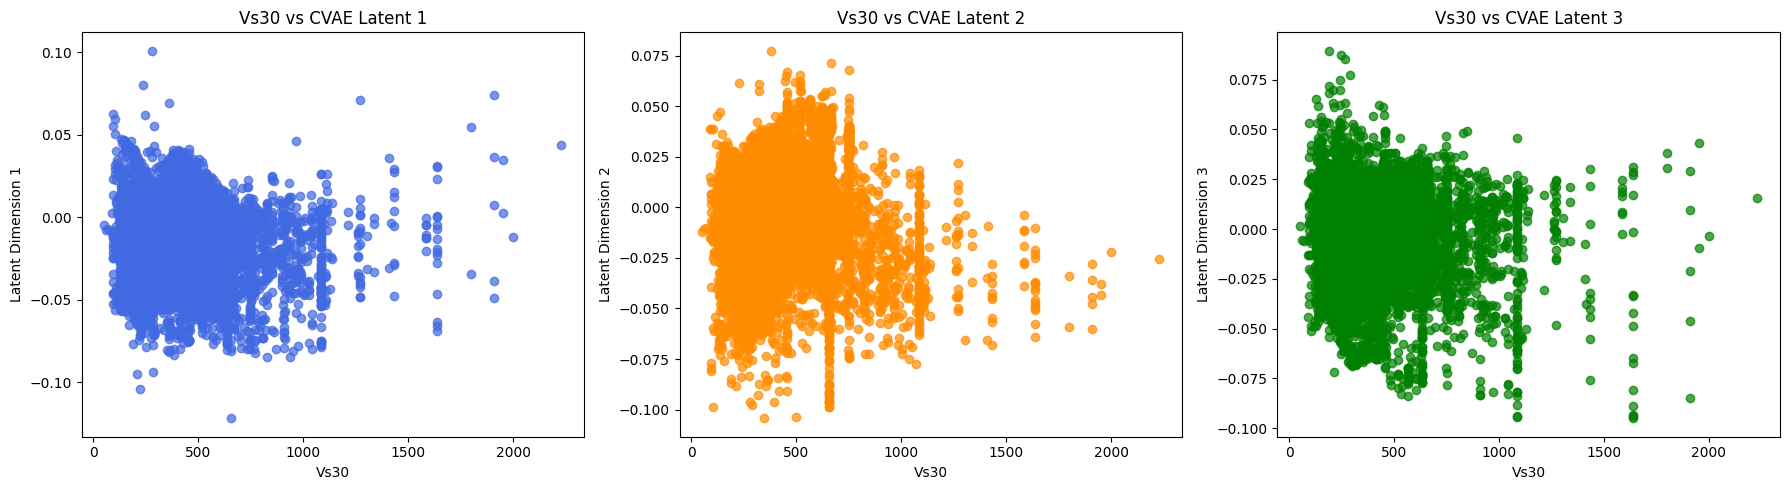

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# --- Get Latent Space for Train Set ---
# Split df_clean same way to get training rows
df_train, df_temp = train_test_split(df_clean, test_size=0.3, random_state=42, stratify=df_clean['intra_inter'])
df_val, df_test_split = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['intra_inter'])

# Extract Rjb values from train set
rjb = df_train['vs30'].values

# Scale the input columns
X_train_plot = scaler_X.transform(df_train[input_cols].values)

# Get z_mean (latent dimensions) from encoder
z_mean_train, _, _ = encoder.predict(X_train_plot)

# Extract first 3 latent components
latent1 = z_mean_train[:, 0]
latent2 = z_mean_train[:, 1]
latent3 = z_mean_train[:, 2]

# --- Plot ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(rjb, latent1, color='royalblue', alpha=0.7)
axs[0].set_title('Vs30 vs CVAE Latent 1')
axs[0].set_xlabel('Vs30')
axs[0].set_ylabel('Latent Dimension 1')

axs[1].scatter(rjb, latent2, color='darkorange', alpha=0.7)
axs[1].set_title('Vs30 vs CVAE Latent 2')
axs[1].set_xlabel('Vs30')
axs[1].set_ylabel('Latent Dimension 2')

axs[2].scatter(rjb, latent3, color='green', alpha=0.7)
axs[2].set_title('Vs30 vs CVAE Latent 3')
axs[2].set_xlabel('Vs30')
axs[2].set_ylabel('Latent Dimension 3')

plt.tight_layout()
plt.show()

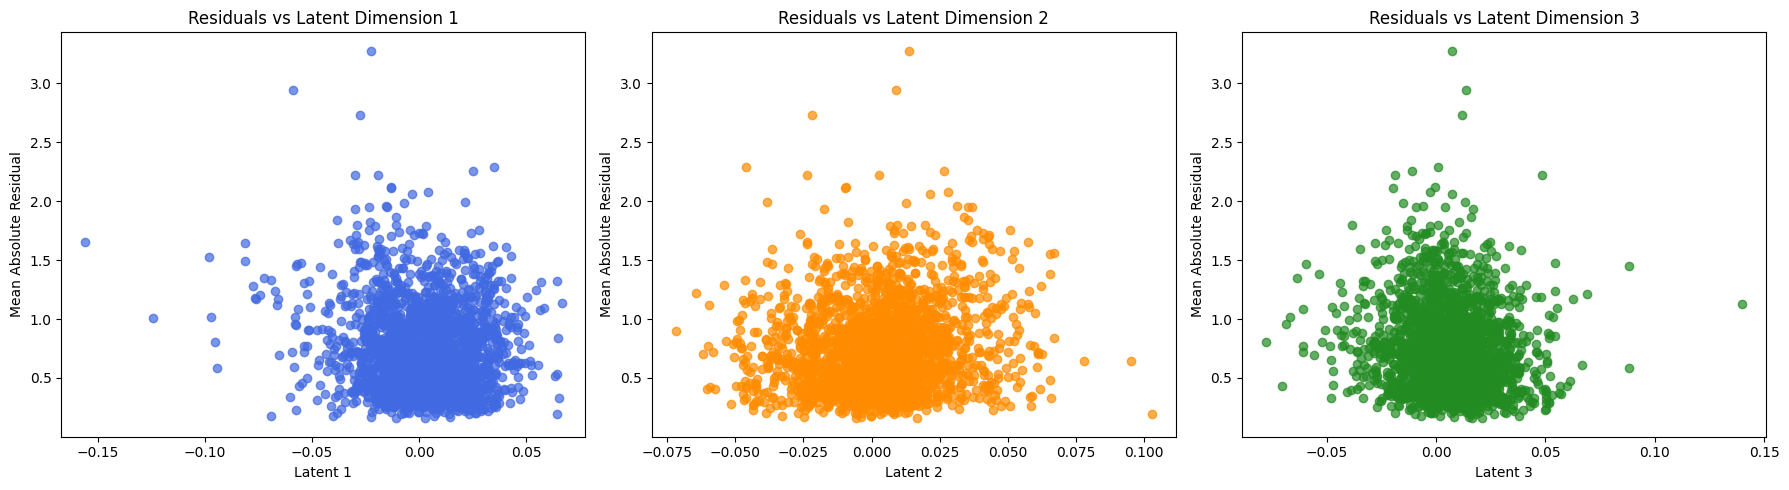

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict SA using trained CVAE decoder
z_mean_test, _, _ = encoder.predict(X_test, verbose=0)
y_pred_scaled = decoder.predict(z_mean_test, verbose=0)

# Inverse scale prediction and ground truth
y_pred = scaler_Y.inverse_transform(y_pred_scaled)
Y_test_unscaled = scaler_Y.inverse_transform(Y_test)

# Step 2: Compute residuals (Mean Absolute Error per test sample)
residuals = Y_test_unscaled - y_pred  # shape: (num_samples, num_outputs)
mae_per_sample = np.mean(np.abs(residuals), axis=1)  # shape: (num_samples,)

# Step 3: Extract CVAE latent components (from encoder applied to X_test)
pca1 = z_mean_test[:, 0]
pca2 = z_mean_test[:, 1]
pca3 = z_mean_test[:, 2]

# Step 4: Plot Residuals vs CVAE latent components
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(pca1, mae_per_sample, alpha=0.7, color='royalblue')
axs[0].set_title('Residuals vs Latent Dimension 1')
axs[0].set_xlabel('Latent 1')
axs[0].set_ylabel('Mean Absolute Residual')

axs[1].scatter(pca2, mae_per_sample, alpha=0.7, color='darkorange')
axs[1].set_title('Residuals vs Latent Dimension 2')
axs[1].set_xlabel('Latent 2')
axs[1].set_ylabel('Mean Absolute Residual')

axs[2].scatter(pca3, mae_per_sample, alpha=0.7, color='forestgreen')
axs[2].set_title('Residuals vs Latent Dimension 3')
axs[2].set_xlabel('Latent 3')
axs[2].set_ylabel('Mean Absolute Residual')

plt.tight_layout()
plt.show()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<ipython-input-9-74fbb21b5aa1>:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby('bin')['x'].mean()
<ipython-input-9-74fbb21b5aa1>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby('bin')['y'].mean()
<ipython-input-9-74fbb21b5aa1>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stds = df_plot.groupby('bin')['y'].std()
<ipython-input-9-74fbb21b5aa1>:33: Futur

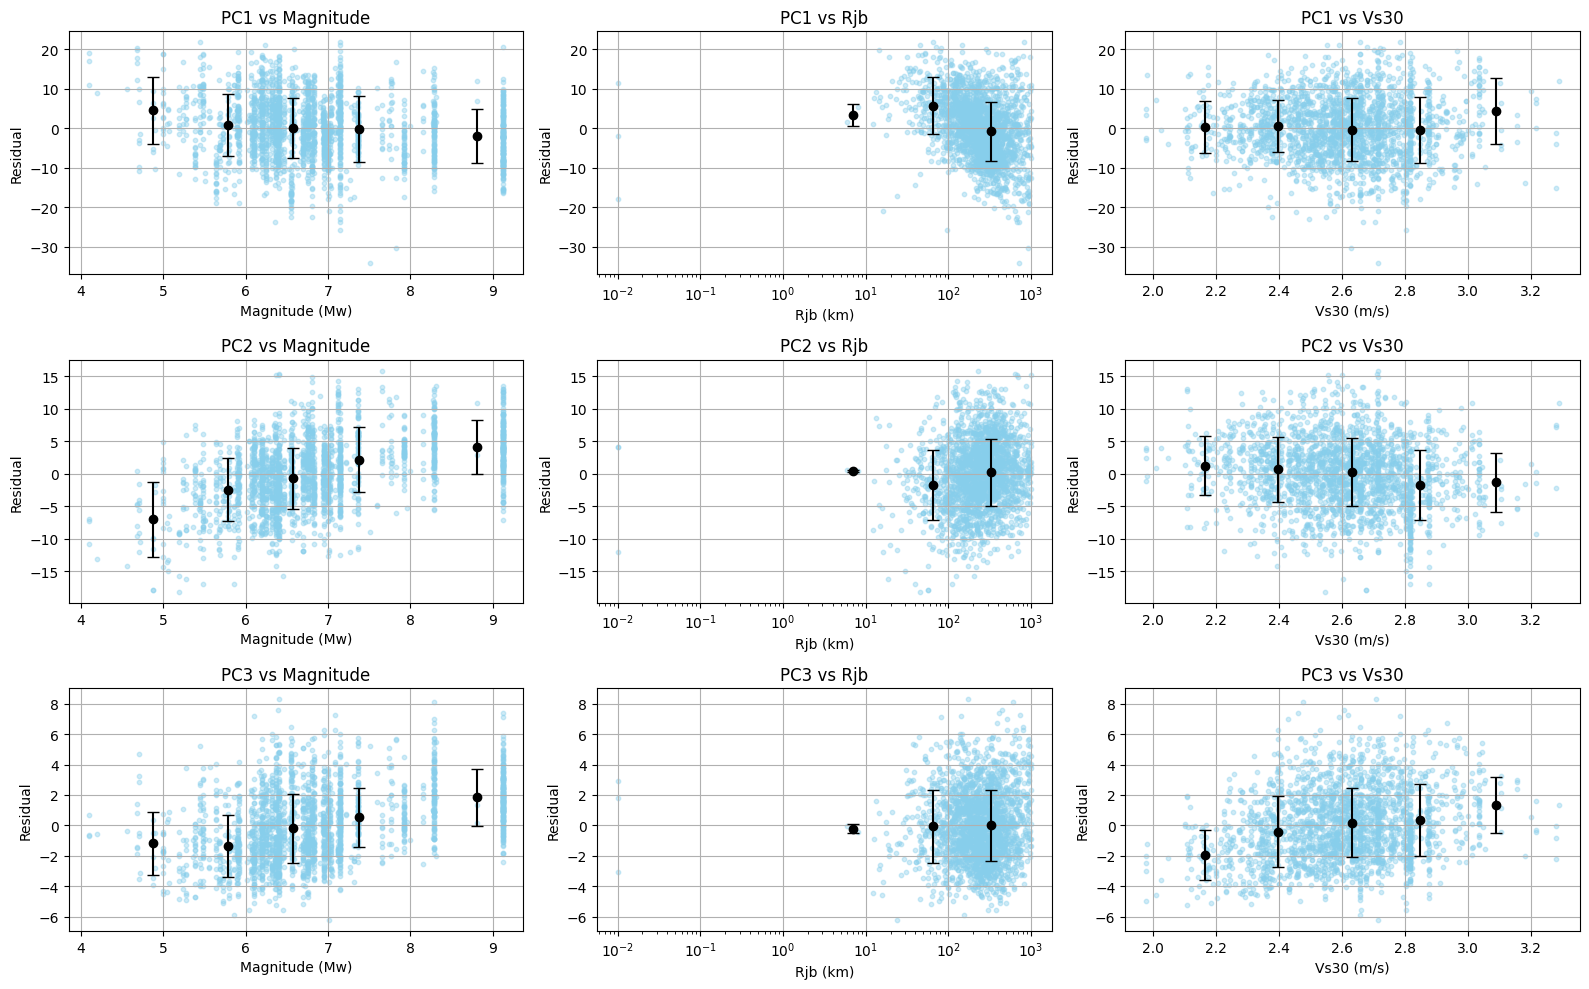

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---- 1. Get predictions from CVAE ----
z_mean, _, _ = encoder.predict(X_test)
y_pred_scaled = decoder.predict(z_mean)

# ---- 2. Inverse scale to get log-space values ----
y_pred_log = scaler_Y.inverse_transform(y_pred_scaled)
y_test_log = scaler_Y.inverse_transform(Y_test)

# ---- 3. Compute residuals ----
residuals_log = y_test_log - y_pred_log

# ---- 4. Perform PCA on residuals ----
pca = PCA(n_components=3)
pca_components = pca.fit_transform(residuals_log)
pc_labels = ['PC1', 'PC2', 'PC3']

# ---- 5. Get predictor variables ----
X_test_unscaled = scaler_X.inverse_transform(X_test)
mag = X_test_unscaled[:, 0]  # Magnitude
rjb = X_test_unscaled[:, 1]  # Joyner-Boore distance
vs30 = X_test_unscaled[:, 3]  # VS30

# ---- 6. Plotting function ----
def plot_residual_binned(x, y, xlabel, title, log_x=False, bins=6, ax=None):
    df_plot = pd.DataFrame({'x': x, 'y': y})
    df_plot['bin'] = pd.cut(df_plot['x'], bins=bins)

    bin_centers = df_plot.groupby('bin')['x'].mean()
    bin_means = df_plot.groupby('bin')['y'].mean()
    bin_stds = df_plot.groupby('bin')['y'].std()

    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, s=10, color='skyblue')
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', capsize=4)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residual")
    ax.set_title(title)
    if log_x:
        ax.set_xscale("log")
    ax.grid(True)

# ---- 7. Create subplots ----
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

for row, pc in enumerate(pca_components.T):
    for col, (x, xlabel, log_flag) in enumerate(zip(
        [mag, rjb, vs30],
        ["Magnitude (Mw)", "Rjb (km)", "Vs30 (m/s)"],
        [False, True, False]
    )):
        plot_residual_binned(
            x,
            pc,
            xlabel=xlabel,
            title=f"{pc_labels[row]} vs {xlabel.split(' ')[0]}",
            log_x=log_flag,
            bins=np.linspace(x.min(), x.max(), 6) if not log_flag else np.logspace(np.log10(x.min()), np.log10(x.max()), 6),
            ax=axs[row, col]
        )

plt.tight_layout()
plt.show()

In [ ]:

!apt-get install graphviz -y
!pip install pydot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


##1) Figures

###Magnitude vs Joyner-Boore distance

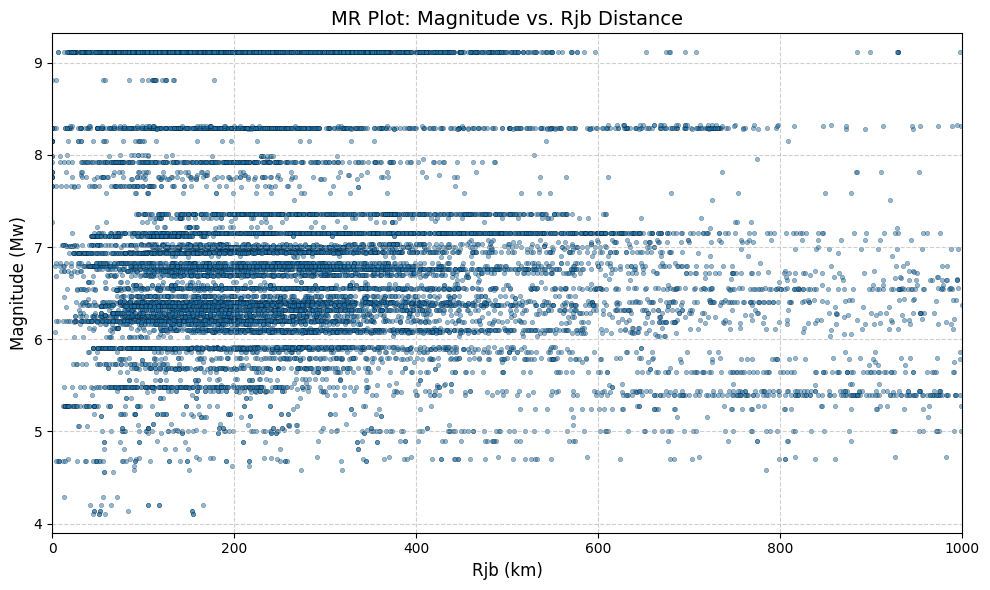

In [ ]:

import matplotlib.pyplot as plt

# Ensure 'mag' and 'rjb' are in the DataFrame
plt.figure(figsize=(10, 6))
plt.scatter(df['rjb'], df['mag'], s=10, alpha=0.5, edgecolors='k', linewidths=0.3)

plt.xlabel('Rjb (km)', fontsize=12)
plt.ylabel('Magnitude (Mw)', fontsize=12)
plt.title('MR Plot: Magnitude vs. Rjb Distance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1000)
plt.ylim(df['mag'].min() - 0.2, df['mag'].max() + 0.2)
plt.tight_layout()
plt.show()

##2) histogram of each input parameter

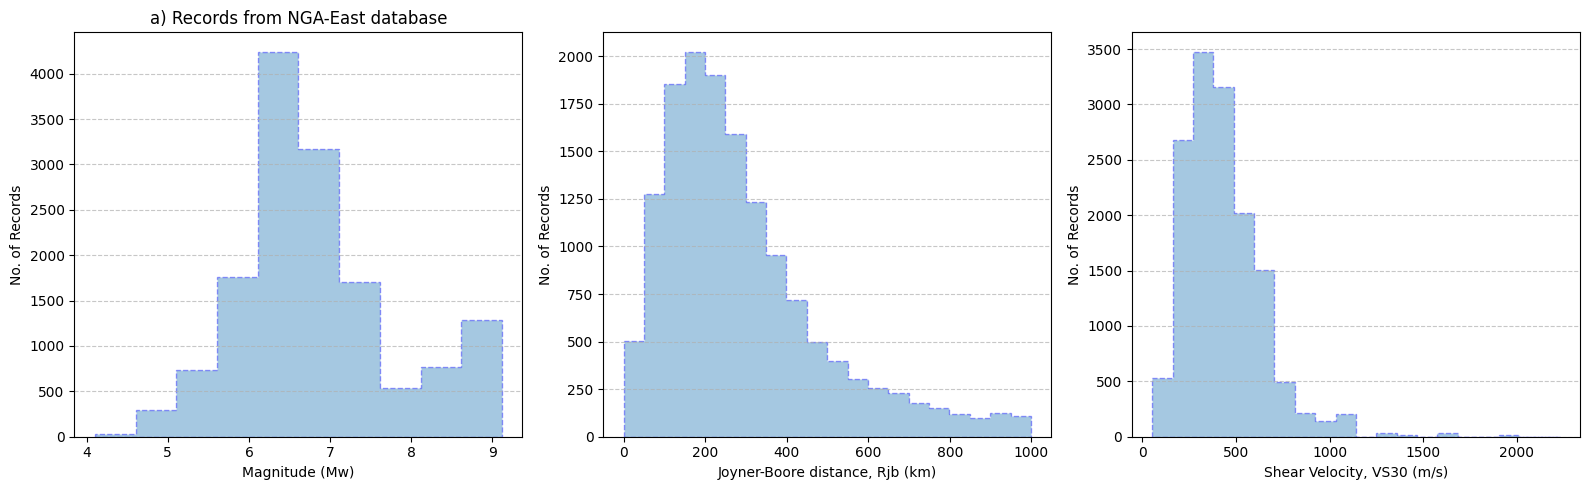

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# 1. Histogram for Magnitude (mag)
axs[0].hist(df["mag"], bins=10, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[0].set_xlabel("Magnitude (Mw)")
axs[0].set_ylabel("No. of Records")
axs[0].set_title("a) Records from NGA-East database")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Histogram for Joyner-Boore Distance (rjb)
axs[1].hist(df["rjb"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[1].set_xlabel("Joyner-Boore distance, Rjb (km)")
axs[1].set_ylabel("No. of Records")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# 4. Histogram for VS30
axs[2].hist(df["vs30"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[2].set_xlabel("Shear Velocity, VS30 (m/s)")
axs[2].set_ylabel("No. of Records")
axs[2].grid(axis='y', linestyle='--', alpha=0.7)


# 3. Horizontal bar plot for Fault_Type
# Clean Fault_Type strings
# Convert 'Fault_Type' to string before applying .str.title()
#df["Fault_Type"] = df["Fault_Type"].astype(str).str.title() # Changed to convert to string
#fault_order = ["Strike Slip", "Normal", "Reverse", "Reverse Oblique"]
#fault_counts = df["Fault_Type"].value_counts().reindex(fault_order, fill_value=0)

#axs[3].barh(fault_counts.index, fault_counts.values, color='skyblue', edgecolor='blue', hatch='//')
#axs[3].set_xlabel("No. of Records")
#axs[3].invert_yaxis()
#axs[3].grid(axis='x', linestyle='--', alpha=0.7)

# Layout
plt.tight_layout()
plt.show()

##Table 1

In [ ]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Create DataFrame for input features
# Use the correct number of columns based on X_train
df_input = pd.DataFrame(X_train, columns=['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter'])

# Compute statistics
summary_stats = pd.DataFrame({
    "Min": df_input.min(),
    "Max": df_input.max(),
    "Mean": df_input.mean(),
    "Std Dev": df_input.std(),
    "Skewness": df_input.apply(skew),
    "Kurtosis": df_input.apply(kurtosis)
})

# Round for readability
summary_stats = summary_stats.round(4)

# Display the table
print(summary_stats)

                 Min     Max    Mean  Std Dev  Skewness  Kurtosis
mag          -2.7242  2.2819 -0.0051   1.0050    0.7756    0.3699
rjb          -1.4710  3.5985 -0.0040   0.9995    1.2978    1.5244
logrjb      -11.7792  1.7523 -0.0031   0.9983   -3.3156   33.7784
logvs30      -4.2637  3.7293 -0.0080   0.9995   -0.1117    0.1058
intra_inter  -0.8566  1.1674  0.0001   1.0001    0.3105   -1.9036


##4) Netwrok Architecture

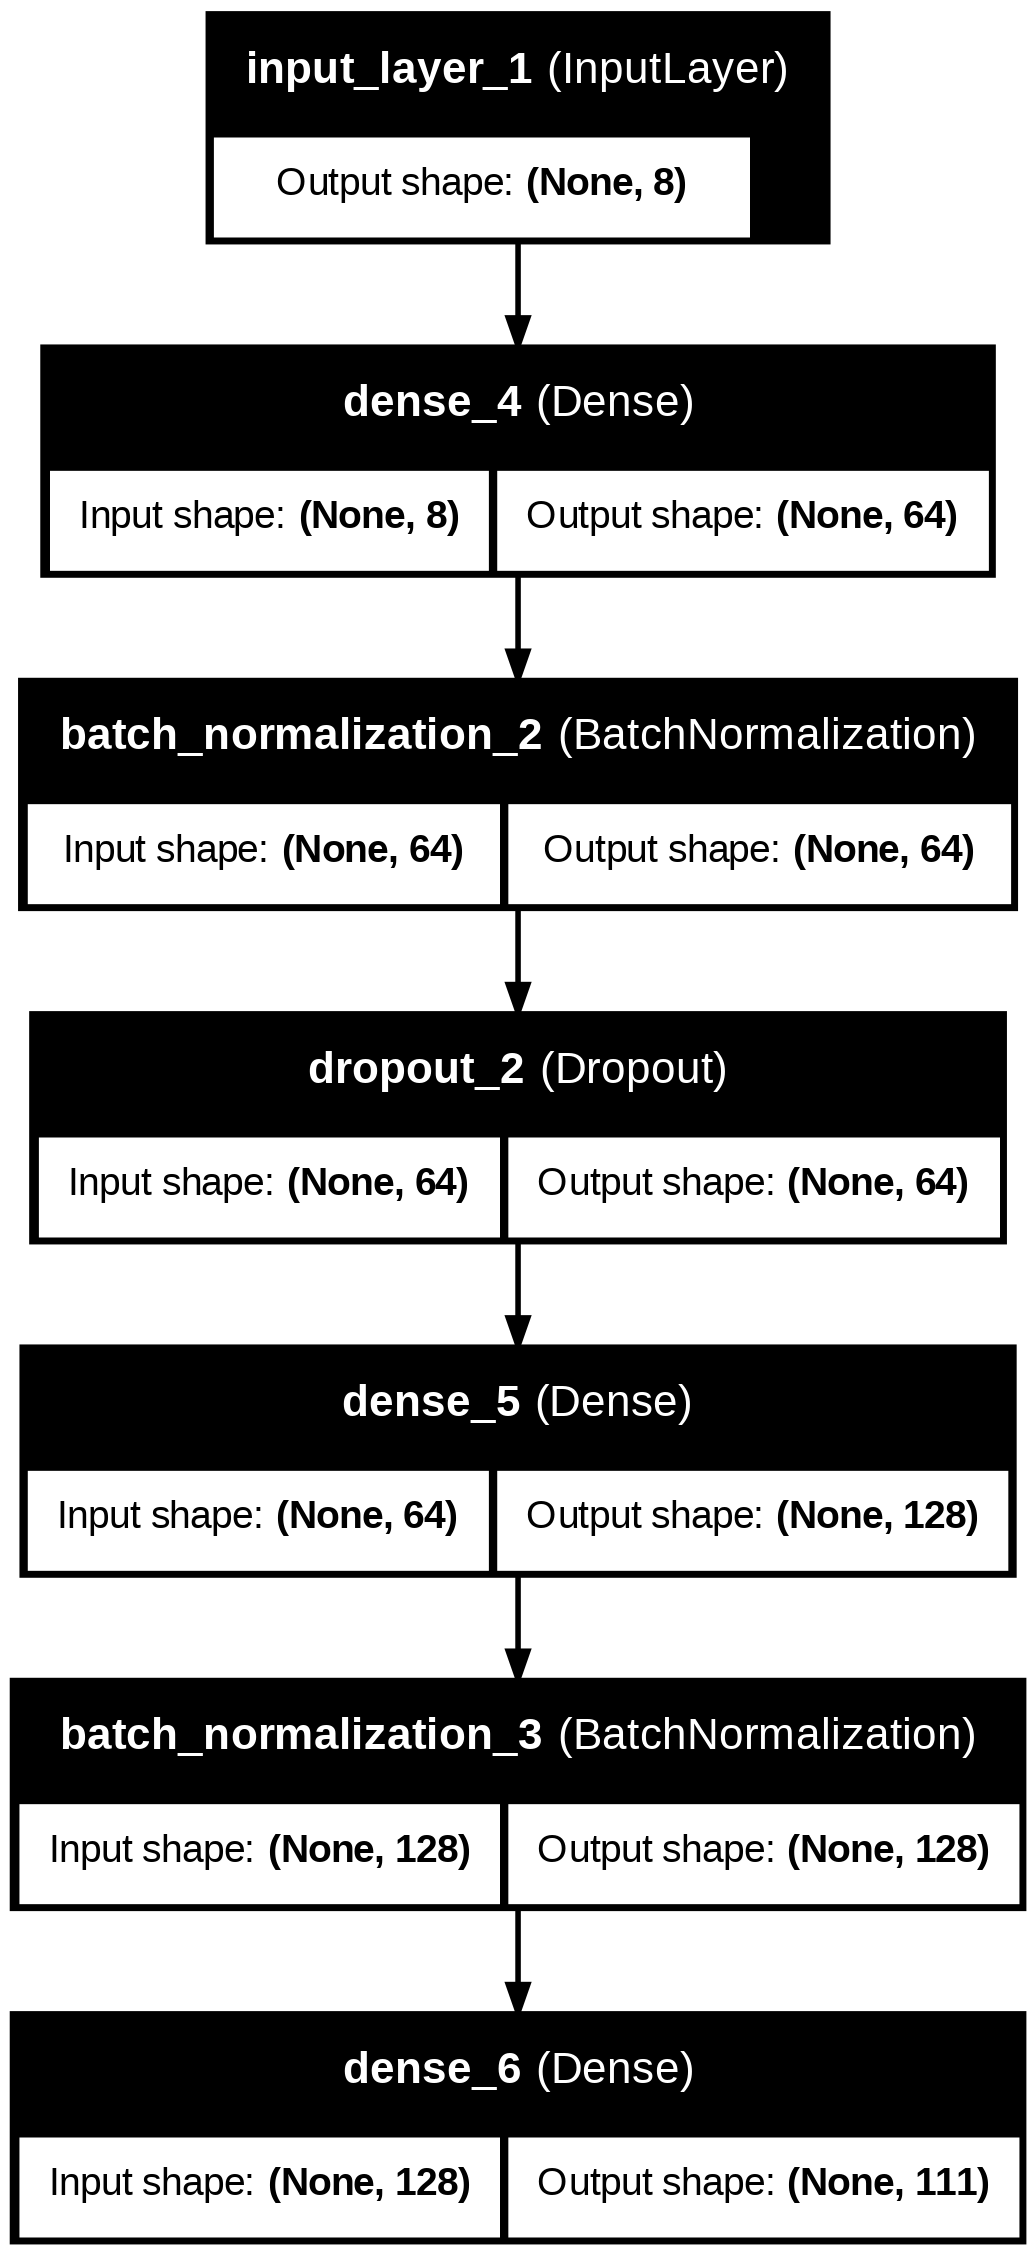

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot encoder
plot_model(encoder, to_file="encoder_architecture.png", show_shapes=True, show_layer_names=True)

# Plot decoder
plot_model(decoder, to_file="decoder_architecture.png", show_shapes=True, show_layer_names=True)


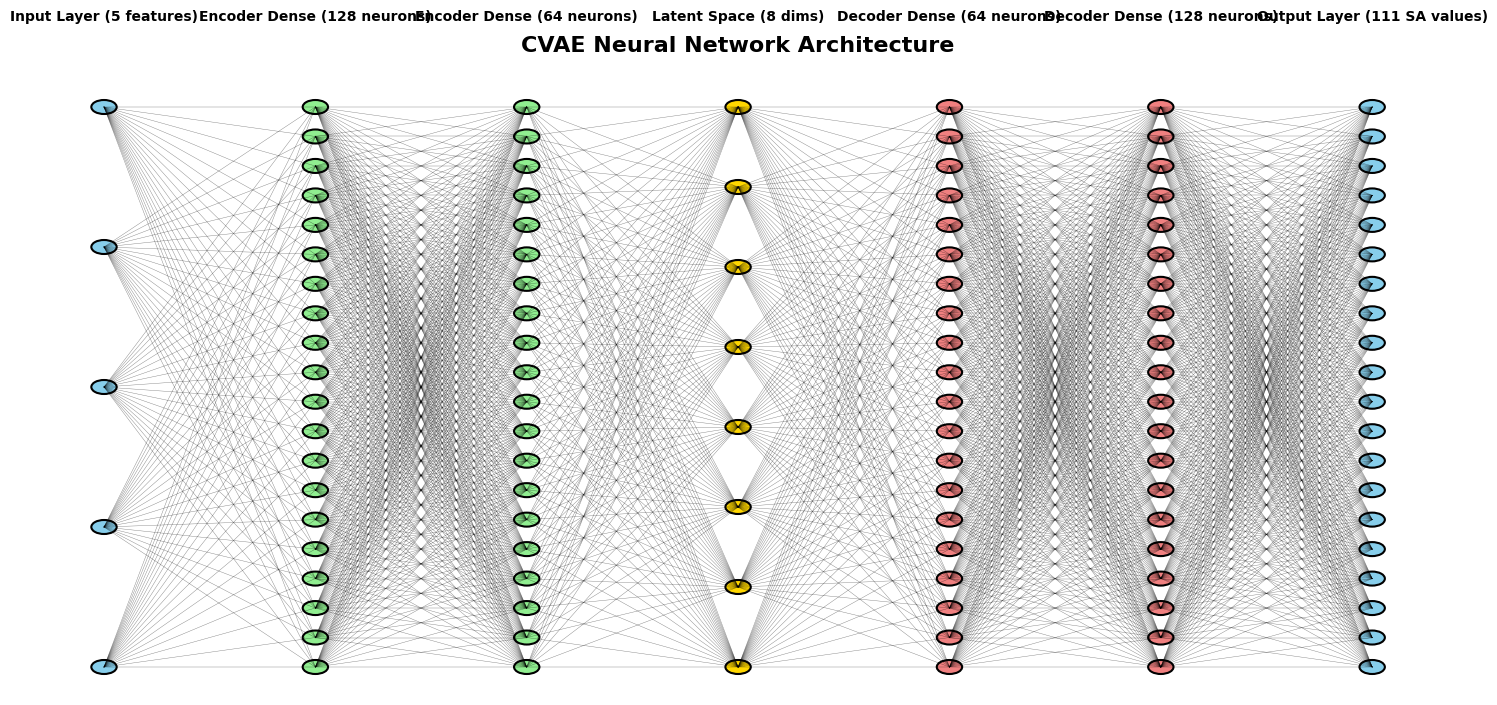

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_cvae_network():
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.axis('off')

    # Define layers based on CVAE architecture
    y_dim = Y_train.shape[1]
    layers = [5, 128, 64, 8, 64, 128, y_dim]  # Encoder + Latent + Decoder

    # X positions of layers
    layer_positions = np.linspace(0, 1, len(layers))

    # Colors
    colors = [
        'skyblue',      # Input
        'lightgreen',   # Encoder Dense 128
        'lightgreen',   # Encoder Dense 64
        'gold',         # Latent space (8)
        'lightcoral',   # Decoder Dense 64
        'lightcoral',   # Decoder Dense 128
        'skyblue'       # Output layer
    ]

    # Draw neurons
    for idx, (x, num_neurons) in enumerate(zip(layer_positions, layers)):
        y_positions = np.linspace(0.1, 0.9, min(num_neurons, 20))  # max 20 circles per layer for visualization
        for y in y_positions:
            circle = plt.Circle((x, y), 0.01, color=colors[idx], ec='black', lw=1.5)
            ax.add_artist(circle)

    # Draw connections
    for idx in range(len(layers) - 1):
        x_start, x_end = layer_positions[idx], layer_positions[idx + 1]
        y_start = np.linspace(0.1, 0.9, min(layers[idx], 20))
        y_end = np.linspace(0.1, 0.9, min(layers[idx + 1], 20))

        for y1 in y_start:
            for y2 in y_end:
                ax.plot([x_start, x_end], [y1, y2], 'k-', lw=0.3, alpha=0.5)

    # Add labels
    layer_labels = [
        'Input Layer (5 features)',
        'Encoder Dense (128 neurons)',
        'Encoder Dense (64 neurons)',
        'Latent Space (8 dims)',
        'Decoder Dense (64 neurons)',
        'Decoder Dense (128 neurons)',
        f'Output Layer ({y_dim} SA values)'
    ]

    for idx, (x, label) in enumerate(zip(layer_positions, layer_labels)):
        ax.text(x, 1.02, label, ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Title
    plt.title('CVAE Neural Network Architecture', fontsize=16, fontweight='bold', pad=20)

    plt.show()

draw_cvae_network()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


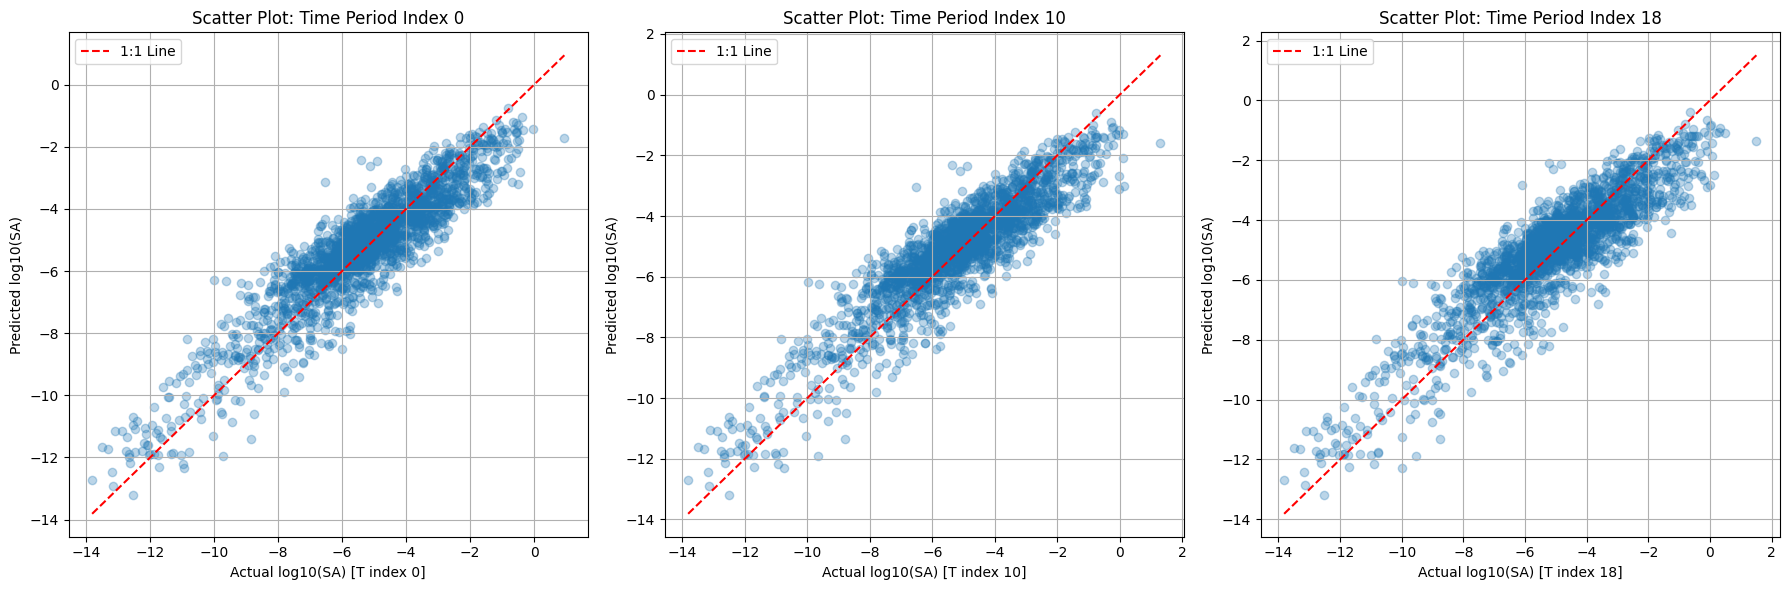

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Encode to latent space
z_mean, _, _ = encoder.predict(X_test) # Only provide X_test as input to the encoder

# Decode (i.e., reconstruct y)
y_pred_scaled = decoder.predict(z_mean)  # Use the encoded z_mean as input to the decoder

# ... (rest of your code) ...
# Inverse transform to original log scale (if you used a scaler)
# Use scaler_Y instead of scaler_target
y_pred_log = scaler_Y.inverse_transform(y_pred_scaled)
y_test_log = scaler_Y.inverse_transform(Y_test)


spectral_indices = [0, 10, 18]  # Choose relevant output indices

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, idx in enumerate(spectral_indices):
    ax = axs[i]
    ax.scatter(y_test_log[:, idx], y_pred_log[:, idx], alpha=0.3)
    ax.plot([y_test_log[:, idx].min(), y_test_log[:, idx].max()],
            [y_test_log[:, idx].min(), y_test_log[:, idx].max()], 'r--', label='1:1 Line')

    ax.set_xlabel(f'Actual log10(SA) [T index {idx}]')
    ax.set_ylabel('Predicted log10(SA)')
    ax.set_title(f'Scatter Plot: Time Period Index {idx}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


##5) Error bar Plots

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<ipython-input-11-b5f8e7321a0d>:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby('bin')['x'].mean() # Changed df to df_plot
<ipython-input-11-b5f8e7321a0d>:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby('bin')['y'].mean() # Changed df to df_plot
<ipython-input-11-b5f8e7321a0d>:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stds = df_plot.groupby('bin')[

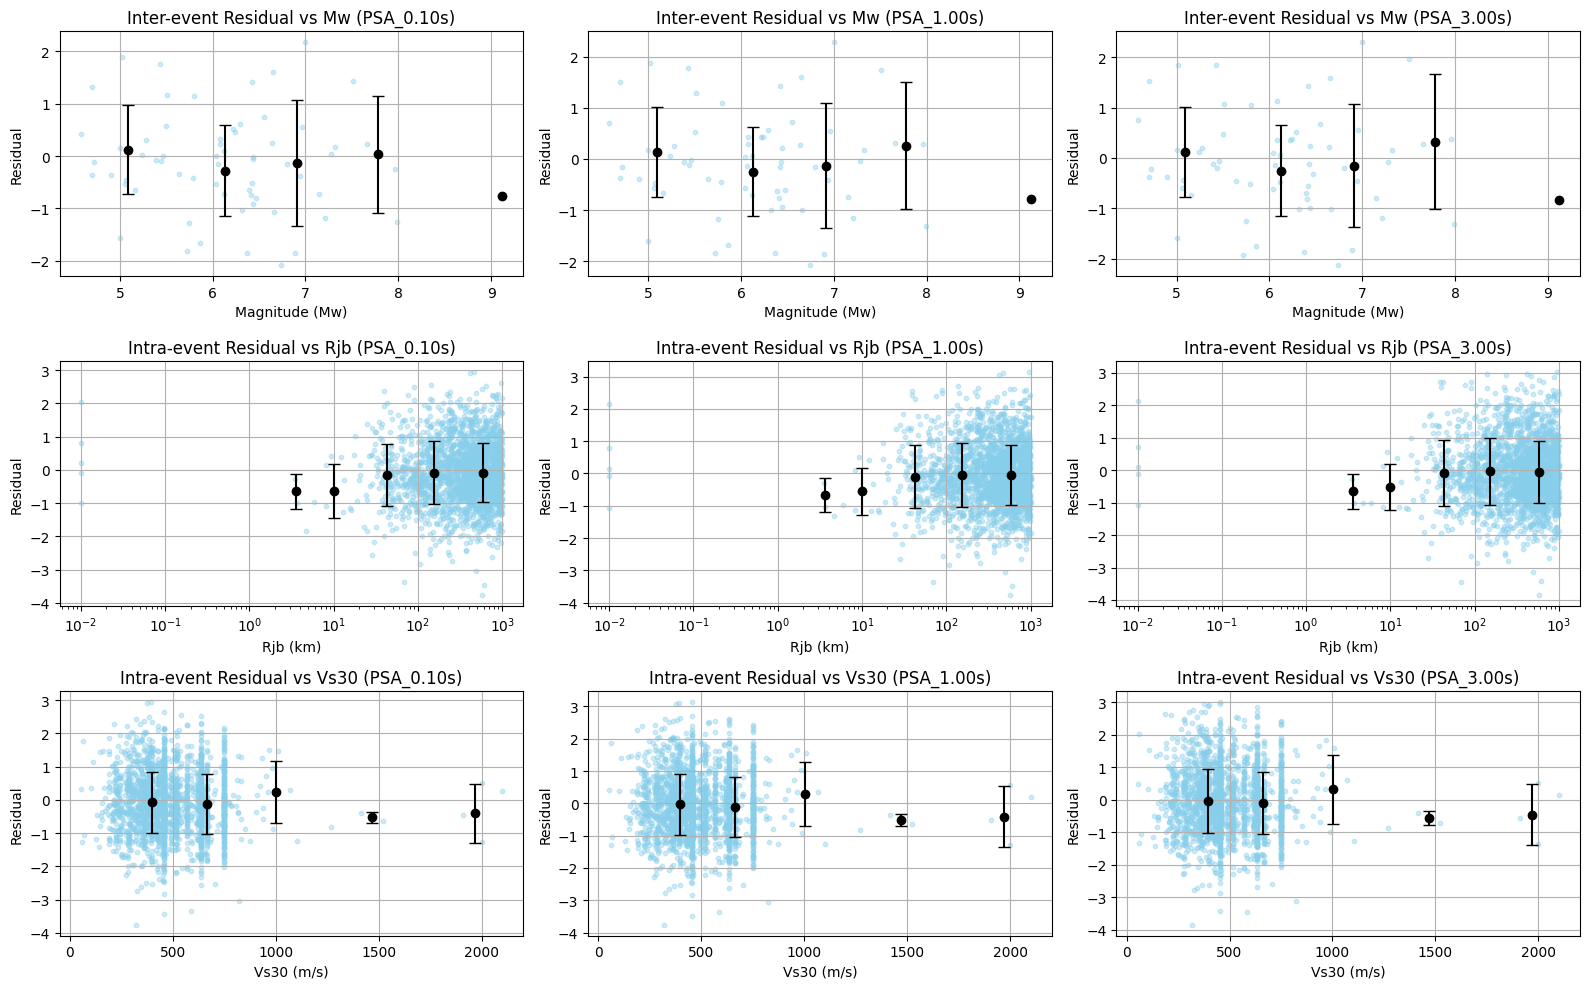

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Get predictions from CVAE ----
#z_mean, _, _ = encoder.predict([X_test, Y_test])
#y_pred_scaled = decoder.predict([X_test, z_mean])

# ---- 1. Get predictions from CVAE ----
z_mean, _, _ = encoder.predict(X_test) # Only provide X_test as input to the encoder
y_pred_scaled = decoder.predict(z_mean) # Only provide the encoded latent representation to the decoder


# ---- 2. Inverse scale to get log-space values ----
y_pred_log = scaler_Y.inverse_transform(y_pred_scaled)
y_test_log = scaler_Y.inverse_transform(Y_test)

# ---- 3. Compute residuals ----
residuals_log = y_test_log - y_pred_log

# ---- 4. Separate inter- and intra-event residuals ----
eq_unique, eq_idx_original = np.unique(EqIDs, return_index=True)
eq_idx = [idx for idx in eq_idx_original if idx < residuals_log.shape[0]]

inter_event = residuals_log[eq_idx]
intra_event = residuals_log

# ---- 5. Labels and Time Periods ----
time_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4,
                0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]
selected_indices = [5, 12, 16]
selected_labels = [f"PSA_{time_periods[i]:.2f}s" for i in selected_indices]




# Plotting function with binned mean/std
def plot_residual_binned(x, y, xlabel, title, log_x=False, bins=6, ax=None):
    df_plot = pd.DataFrame({'x': x, 'y': y}) # Changed df to df_plot to avoid name conflict
    df_plot['bin'] = pd.cut(df_plot['x'], bins=bins) # Changed df to df_plot

    bin_centers = df_plot.groupby('bin')['x'].mean() # Changed df to df_plot
    bin_means = df_plot.groupby('bin')['y'].mean() # Changed df to df_plot
    bin_stds = df_plot.groupby('bin')['y'].std() # Changed df to df_plot

    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, s=10, color='skyblue')
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', capsize=4)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residual")
    ax.set_title(title)
    if log_x:
        ax.set_xscale("log")
    ax.grid(True)







# ---- 6. Plotting ----
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

for col, i in enumerate(selected_indices):
    # Magnitude (Mw) for inter-event residuals
    Mw_vals = df['mag'].values[eq_idx_original]
    Mw_vals_filtered = Mw_vals[np.array(eq_idx_original) < residuals_log.shape[0]]

    plot_residual_binned(
        Mw_vals_filtered,
        inter_event[:, i],
        xlabel="Magnitude (Mw)",
        title=f"Inter-event Residual vs Mw ({selected_labels[col]})",
        bins=np.linspace(4.5, 9.5, 6),
        ax=axs[0, col]
    )

    # Rjb for intra-event
    plot_residual_binned(
        df['rjb'].values[:intra_event.shape[0]],
        intra_event[:, i],
        xlabel="Rjb (km)",
        title=f"Intra-event Residual vs Rjb ({selected_labels[col]})",
        bins=np.logspace(0, 3, 6),
        log_x=True,
        ax=axs[1, col]
    )

    # Vs30 for intra-event
    plot_residual_binned(
        df['vs30'].values[:intra_event.shape[0]],
        intra_event[:, i],
        xlabel="Vs30 (m/s)",
        title=f"Intra-event Residual vs Vs30 ({selected_labels[col]})",
        bins=np.linspace(180, 2000, 6),
        ax=axs[2, col]
    )

plt.tight_layout()
plt.show()


##6) Ground Motion Physics

###a- Spectral Acceleration vs Time Period at different Magnitudes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/ste

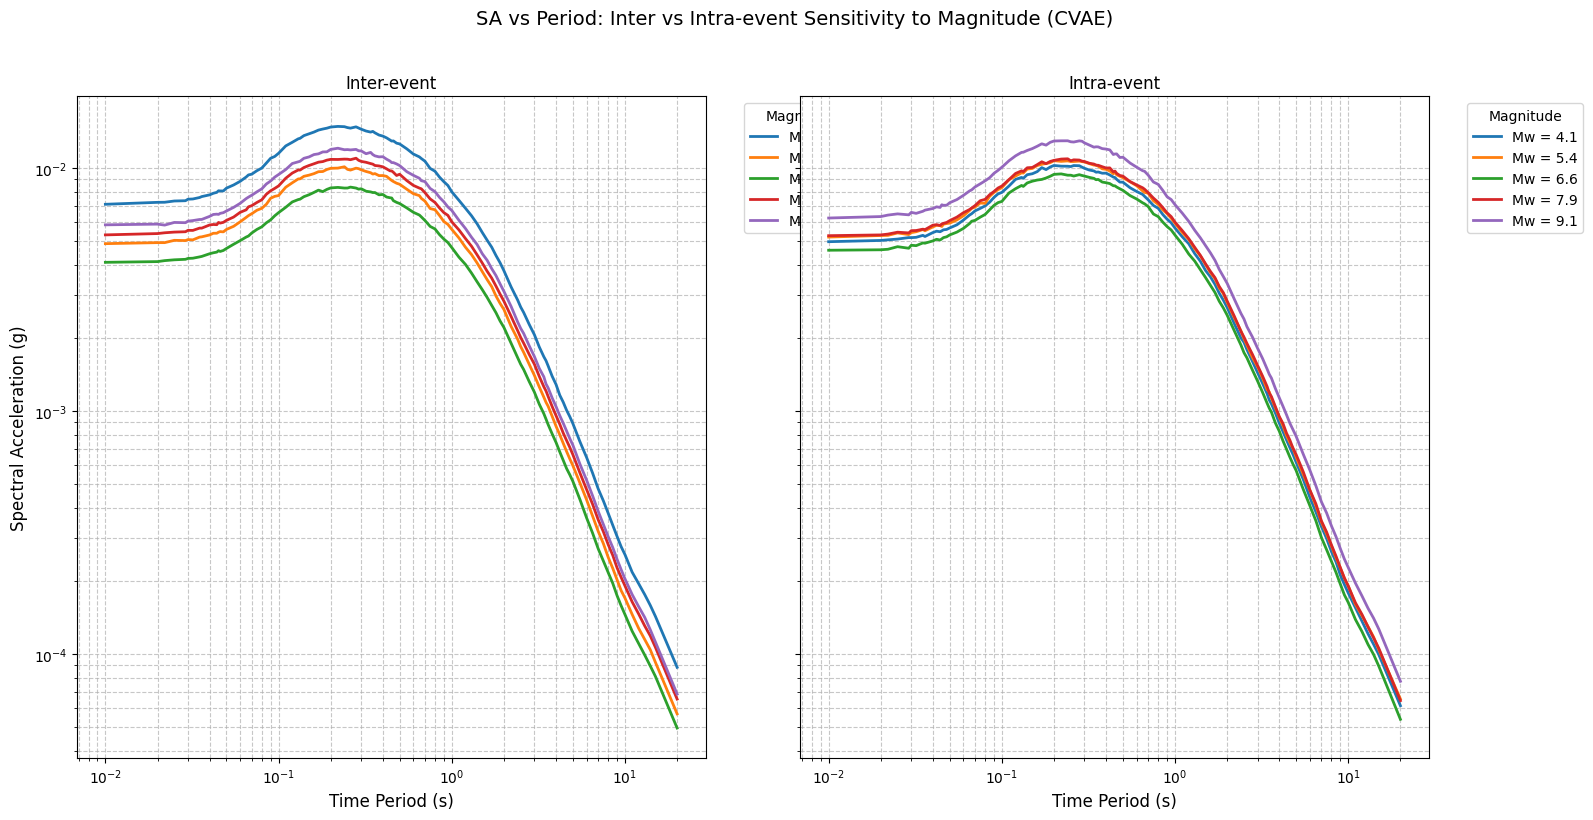

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Periods from target column names
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed input values
fixed_rjb = 10.0
fixed_vs30 = 760.0
logrjb = np.log10(max(fixed_rjb, 0.01))
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Magnitude range
mw_range = np.linspace(df['mag'].min(), df['mag'].max(), 5)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for mw in mw_range:
        # 1. Construct input
        X_input = np.array([[mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_X.transform(X_input)

        # 2. Sample z and generate predictions
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            z = np.random.normal(size=(1, latent_dim))  # latent_dim: set this to match your CVAE
            #y_pred_scaled = decoder.predict([X_scaled, z])
            y_pred_scaled = decoder.predict(z)
            predictions.append(y_pred_scaled)

        predictions = np.array(predictions).squeeze()  # Shape: (100, num_outputs)

        # 3. Mean prediction → log space → exp
        mean_pred_scaled = predictions.mean(axis=0).reshape(1, -1)
        y_pred_log = scaler_Y.inverse_transform(mean_pred_scaled)
        y_pred = np.exp(y_pred_log).flatten()

        # 4. Plot
        label = f'Mw = {mw:.1f}'
        ax.semilogy(periods, y_pred, label=label, linewidth=2)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=12)
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.set_xscale('log')
    ax.grid(True, which="both", linestyle='--', alpha=0.7)
    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)
    ax.legend(title="Magnitude", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Magnitude (CVAE)", fontsize=14, y=1.02)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.show()


###6b- Spectral Acceleration vs Time Period at different Joyner-Boore distance

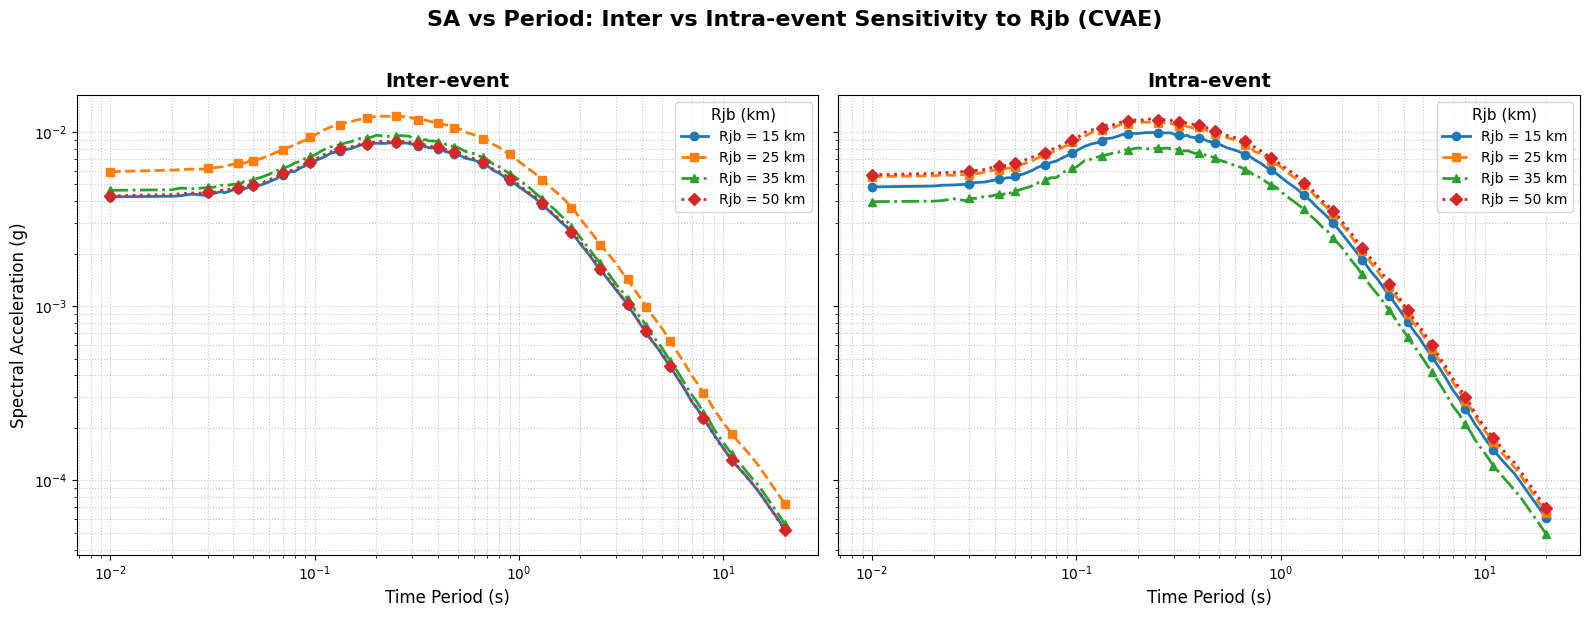

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert periods from target column names
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed values
fixed_mw = 6.5
fixed_vs30 = 760.0
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Rjb values to test
rjb_values = [15, 25, 35, 50]
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

# Latent dimension for CVAE
latent_dim = 8  # ⬅️ Change this to match your model's latent space

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for i, rjb in enumerate(rjb_values):
        logrjb = np.log10(max(rjb, 0.01))
        X_input = np.array([[fixed_mw, rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_X.transform(X_input)

        # Generate predictions from CVAE
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            z = np.random.normal(size=(1, latent_dim))
            #y_pred_scaled = decoder.predict([X_scaled, z], verbose=0)
            y_pred_scaled = decoder.predict(z, verbose=0)
            predictions.append(y_pred_scaled)

        predictions = np.array(predictions).squeeze()  # Shape: (100, num_outputs)
        mean_pred_scaled = predictions.mean(axis=0).reshape(1, -1)
        y_pred_log = scaler_Y.inverse_transform(mean_pred_scaled)
        y_pred = np.exp(y_pred_log).flatten()

        label = f'Rjb = {rjb} km'
        ax.plot(periods, y_pred,
                linestyle=line_styles[i % len(line_styles)],
                marker=markers[i % len(markers)],
                markevery=5,
                linewidth=2,
                label=label)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=14, weight='bold')
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)
    ax.legend(title="Rjb (km)", fontsize=10, title_fontsize=11)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Rjb (CVAE)", fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


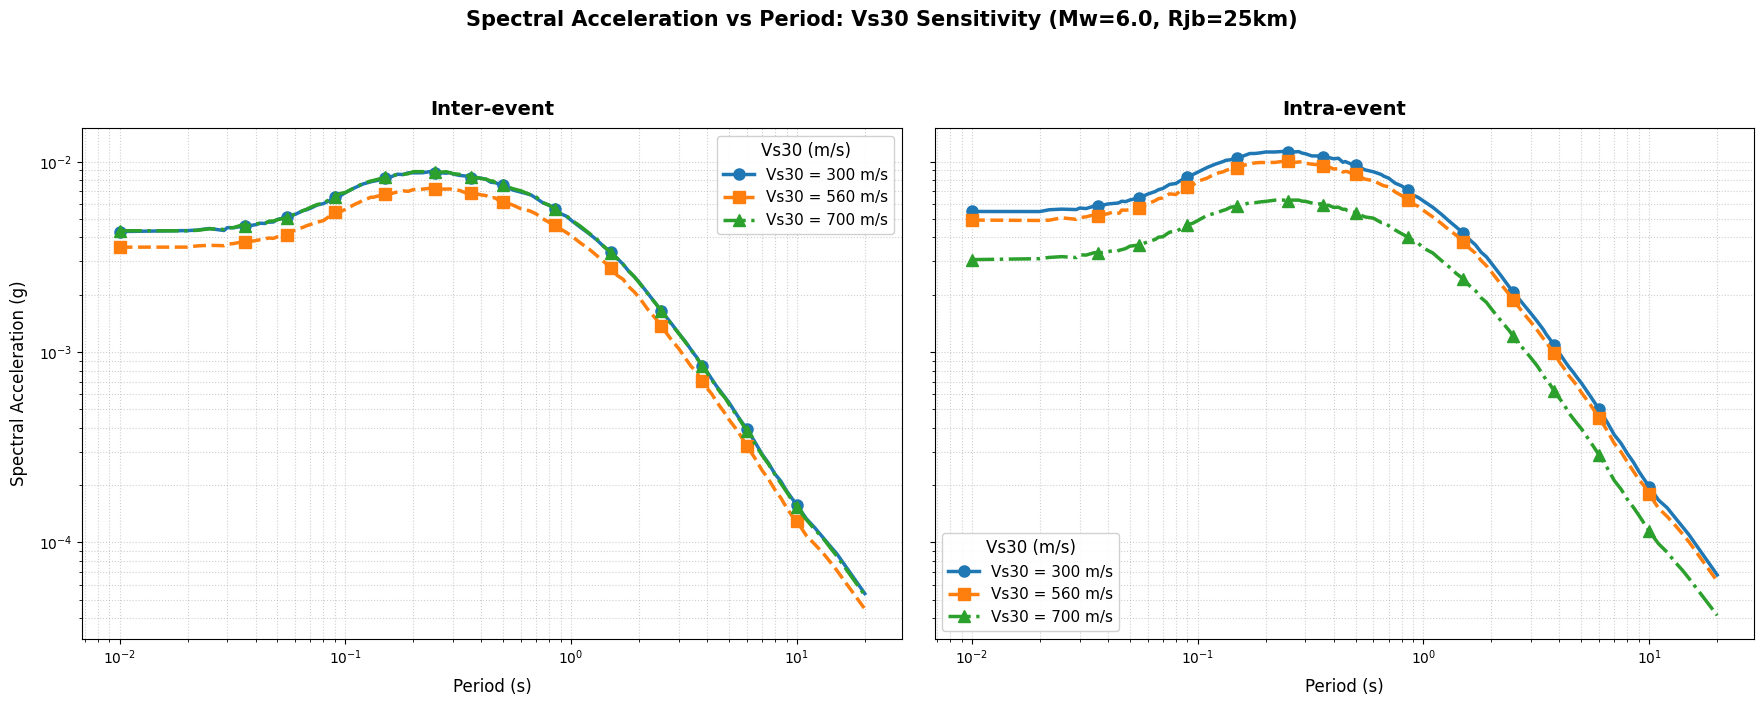

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert period strings to floats
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed inputs
fixed_mw = 6.0
fixed_rjb = 25.0
logrjb = np.log10(max(fixed_rjb, 0.01))

vs30_values = [300, 560, 700]
styles = {
    300: {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o', 'linewidth': 2.5},
    560: {'color': '#ff7f0e', 'linestyle': '--', 'marker': 's', 'linewidth': 2.5},
    700: {'color': '#2ca02c', 'linestyle': '-.', 'marker': '^', 'linewidth': 2.5},
}

latent_dim = 8  # 🔁 Set this to match your CVAE latent dimension

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]

    for vs30 in vs30_values:
        logvs30 = np.log10(max(vs30, 0.01))
        X_input = np.array([[fixed_mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_X.transform(X_input)

        # Sample predictions from CVAE decoder
        predictions = []
        num_samples = 100
        for _ in range(num_samples):
            z = np.random.normal(size=(1, latent_dim))
            # The decoder only expects the latent representation 'z' as input
            y_pred_scaled = decoder.predict(z, verbose=0)
            predictions.append(y_pred_scaled)

        predictions = np.array(predictions).squeeze()  # Shape: (100, num_outputs)
        mean_pred_scaled = predictions.mean(axis=0).reshape(1, -1)
        y_pred_log = scaler_Y.inverse_transform(mean_pred_scaled)
        y_pred = np.exp(y_pred_log).flatten()

        ax.plot(periods, y_pred,
                label=f'Vs30 = {vs30} m/s',
                **styles[vs30],
                markersize=8,
                markevery=8)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event",
                 fontsize=14, pad=10, weight='bold')
    ax.set_xlabel("Period (s)", fontsize=12, labelpad=8)
    ax.grid(True, which='both', linestyle=':', alpha=0.6)

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12, labelpad=8)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(title="Vs30 (m/s)",
              fontsize=11,
              title_fontsize=12,
              framealpha=0.9,
              loc='upper right' if intra_inter_val == 0 else 'lower left')

plt.suptitle("Spectral Acceleration vs Period: Vs30 Sensitivity (Mw=6.0, Rjb=25km)",
             fontsize=15, weight='bold', y=1.02)
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
def get_cvae_prediction(X_input, iT, num_samples=100):
    X_scaled = scaler_X.transform(X_input)
    X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)

    z_mean, z_log_var, _ = encoder(X_tensor)

    preds = []
    for _ in range(num_samples):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sample = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        y_pred_scaled = decoder(z_sample)
        y_pred = scaler_Y.inverse_transform(y_pred_scaled.numpy())
        preds.append(np.exp(y_pred[:, iT]))  # inverse log and extract iT column

    preds = np.array(preds)
    return preds.mean(axis=0)[0]  # Return mean SA for single input


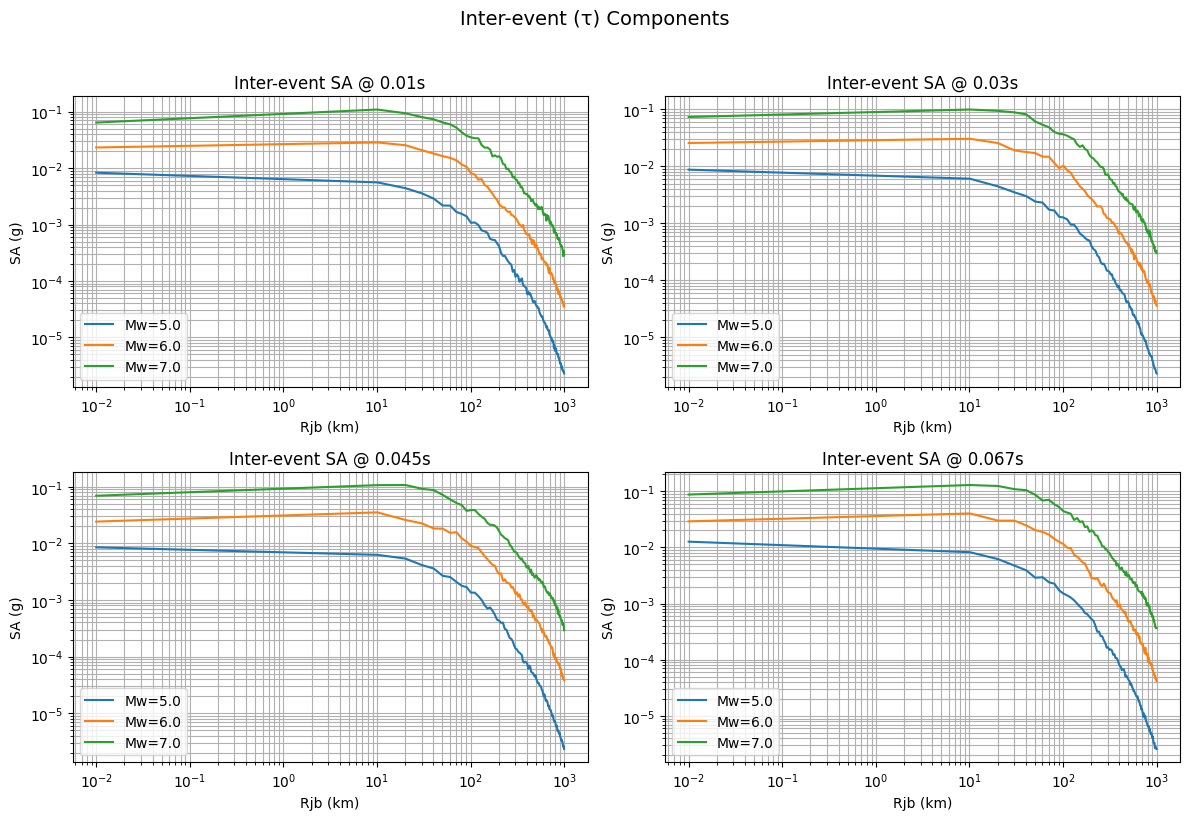

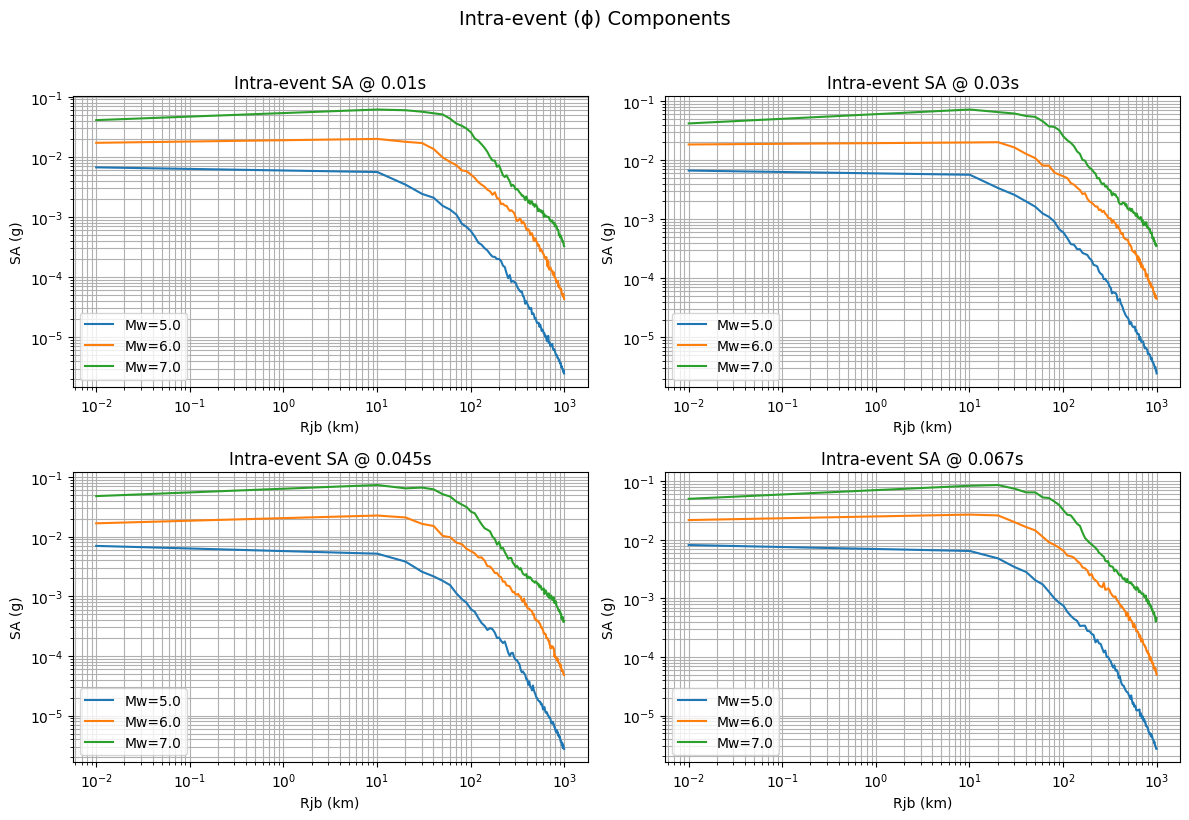

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

selected_period_indices = [0, 5, 12, 19]
selected_periods = [float(target_cols[i][1:].replace('pt', '.').replace('S', '')) for i in selected_period_indices]

rjb_range = np.linspace(df['rjb'].min(), df['rjb'].max(), 100)
mw_values = [5.0, 6.0, 7.0]
fixed_vs30 = 760
logvs30 = np.log10(fixed_vs30)

# ========== 1. Inter-event (τ) Components ==========
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 1]])  # inter-event
            sa = get_cvae_prediction(X_input, iT)
            sa_values.append(sa)

        plt.plot(rjb_range, sa_values, label=f'Mw={mw}')
        plt.xscale("log")
        plt.yscale("log")

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Inter-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Inter-event (τ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ========== 2. Intra-event (ϕ) Components ==========
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 0]])  # intra-event
            sa = get_cvae_prediction(X_input, iT)
            sa_values.append(sa)

        plt.plot(rjb_range, sa_values, label=f'Mw={mw}')
        plt.xscale("log")
        plt.yscale("log")

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Intra-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Intra-event (ϕ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


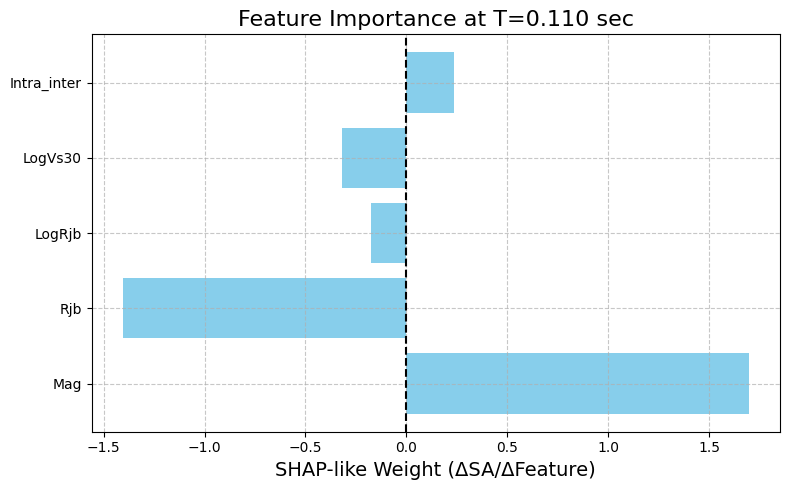

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Input feature names
input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']
features = ['Mag', 'Rjb', 'LogRjb', 'LogVs30', 'Intra_inter']  # Update labels


# Select a subset of inputs to estimate feature importance (e.g., first 100)
N_samples = 100
X_base = X_scaled[:N_samples]  # already scaled

# Predict using encoder -> decoder pipeline
z_mean, _, _ = encoder.predict(X_base)
Y_preds_scaled = decoder.predict(z_mean)
Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)

# Time periods (get from your target columns)
t = np.array([float(c[1:].replace('pt', '.').replace('S', '')) for c in target_cols])
random_idx = np.random.randint(0, len(t))
random_period = t[random_idx]

# Compute SHAP-like importance
epsilon = 1e-2
feature_importances = []

for i in range(len(input_cols)):  # Fix: Iterate over input_cols length
    X_perturbed = X_base.copy()
    X_perturbed[:, i] += epsilon

    # Predict with perturbed inputs
    z_mean_perturbed, _, _ = encoder.predict(X_perturbed)
    Y_preds_perturbed_scaled = decoder.predict(z_mean_perturbed)
    Y_preds_perturbed = scaler_Y.inverse_transform(Y_preds_perturbed_scaled)

    # Compute average change in prediction for the selected period
    delta = Y_preds_perturbed[:, random_idx].mean() - Y_preds[:, random_idx].mean()
    feature_importances.append(delta / epsilon)  # approximate derivative

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(features, feature_importances, color='skyblue')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("SHAP-like Weight (ΔSA/ΔFeature)", fontsize=14)
plt.title(f"Feature Importance at T={random_period:.3f} sec", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

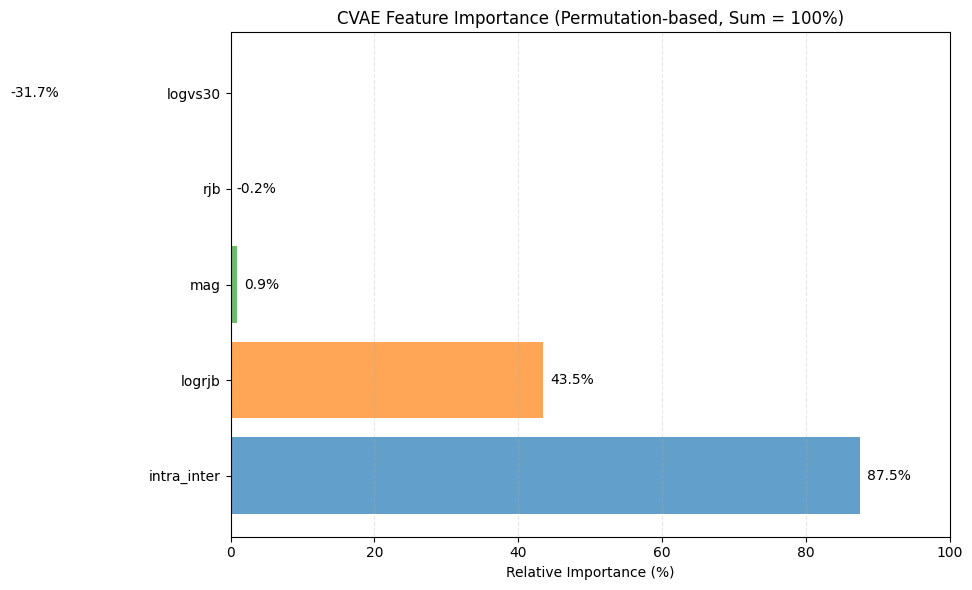

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def cvae_scoring_fn(model, X, Y_true, scaler_input, scaler_target):
    """
    Computes MSE of CVAE predictions on given data.
    """
    X_scaled = scaler_input.transform(X)
    Y_scaled = scaler_target.transform(Y_true)

    z_mean, _, _ = model.encoder.predict(X_scaled, verbose=0)
    Y_pred_scaled = model.decoder.predict(z_mean, verbose=0)

    Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
    Y_true = scaler_target.inverse_transform(Y_scaled)

    return mean_squared_error(Y_true, Y_pred)

def compute_permutation_importance_cvae(model, X_val, Y_val, input_cols, scaler_input, scaler_target, n_repeats=10):
    baseline_score = cvae_scoring_fn(model, X_val, Y_val, scaler_input, scaler_target)
    importances = np.zeros(len(input_cols))

    for i in range(len(input_cols)):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_val.copy()
            np.random.shuffle(X_permuted[:, i])  # Shuffle only column i
            score = cvae_scoring_fn(model, X_permuted, Y_val, scaler_input, scaler_target)
            scores.append(score)
        importances[i] = np.mean(scores) - baseline_score

    # Normalize to percentage
    total_importance = np.sum(np.abs(importances))
    normalized = np.round((importances / total_importance) * 100, 1)
    normalized[-1] += 100 - np.round(np.sum(normalized), 1)

    return normalized

# --- Run Importance ---
normalized_importance = compute_permutation_importance_cvae(
    cvae, X_val, Y_val, input_cols, scaler_X, scaler_Y, n_repeats=10
)

# --- Plot ---
sorted_idx = np.argsort(normalized_importance)[::-1]
sorted_features = np.array(input_cols)[sorted_idx]
sorted_importance = normalized_importance[sorted_idx]

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors
bars = plt.barh(range(len(sorted_features)), sorted_importance, color=colors, alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f"{width:.1f}%", va='center', ha='left')

plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlim(0, 100)
plt.xlabel("Relative Importance (%)")
plt.title("CVAE Feature Importance (Permutation-based, Sum = 100%)")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def build_cvae(hidden_units, latent_dim, learning_rate):
    # Encoder
    input_layer = Input(shape=(X_train.shape[1],))
    x = Dense(hidden_units[0], activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(hidden_units[1], activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling)([z_mean, z_log_var])
    encoder = Model(input_layer, [z_mean, z_log_var, z])

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(hidden_units[1], activation='relu')(latent_inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(hidden_units[0], activation='relu')(x)
    x = BatchNormalization()(x)
    output_layer = Dense(Y_train.shape[1], activation='linear')(x)
    decoder = Model(latent_inputs, output_layer)

    # CVAE Model
    cvae = CVAE(encoder, decoder)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    cvae.compile(optimizer=optimizer)
    return cvae, encoder, decoder


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


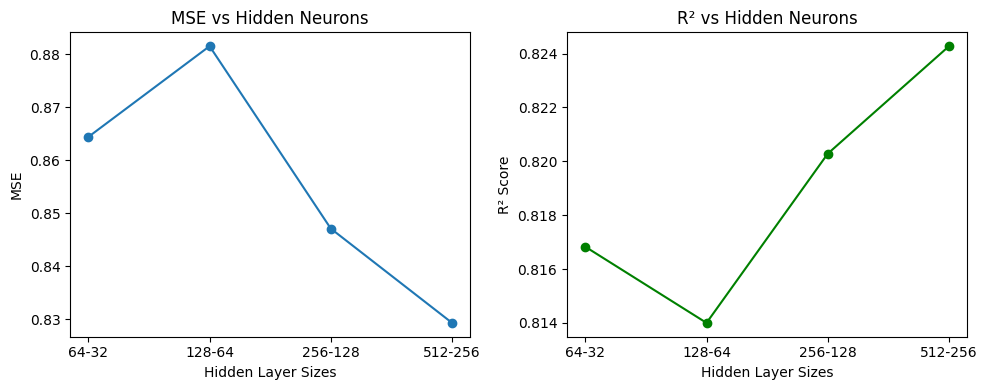

In [ ]:
import matplotlib.pyplot as plt

neurons_list = [(64, 32), (128, 64), (256, 128), (512, 256)]
mse_list, r2_list = [], []

for units in neurons_list:
    cvae, enc, dec = build_cvae(units, latent_dim=8, learning_rate=0.001)
    cvae.fit(X_train, Y_train, validation_data=(X_val, Y_val),
             epochs=100, batch_size=32, verbose=0)

    z_mean_test, _, _ = enc.predict(X_test)
    y_pred_scaled = dec.predict(z_mean_test)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled)
    y_true = scaler_Y.inverse_transform(Y_test)

    mse_list.append(mean_squared_error(y_true, y_pred))
    r2_list.append(r2_score(y_true, y_pred))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot([f"{a}-{b}" for a, b in neurons_list], mse_list, marker='o')
plt.title("MSE vs Hidden Neurons")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("MSE")

plt.subplot(1, 2, 2)
plt.plot([f"{a}-{b}" for a, b in neurons_list], r2_list, marker='o', color='green')
plt.title("R² vs Hidden Neurons")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


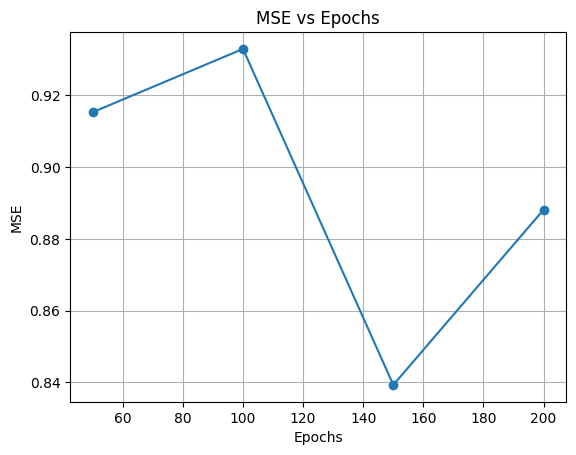

In [ ]:
epoch_list = [50, 100, 150, 200]
mse_epochs = []

for ep in epoch_list:
    cvae, enc, dec = build_cvae((128, 64), latent_dim=8, learning_rate=0.001)
    cvae.fit(X_train, Y_train, validation_data=(X_val, Y_val),
             epochs=ep, batch_size=32, verbose=0)

    z_mean_test, _, _ = enc.predict(X_test)
    y_pred_scaled = dec.predict(z_mean_test)
    y_pred = scaler_Y.inverse_transform(y_pred_scaled)
    mse_epochs.append(mean_squared_error(scaler_Y.inverse_transform(Y_test), y_pred))

plt.plot(epoch_list, mse_epochs, marker='o')
plt.title("MSE vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


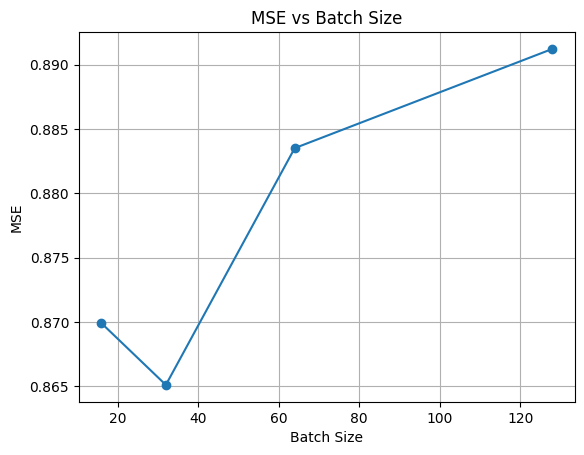

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


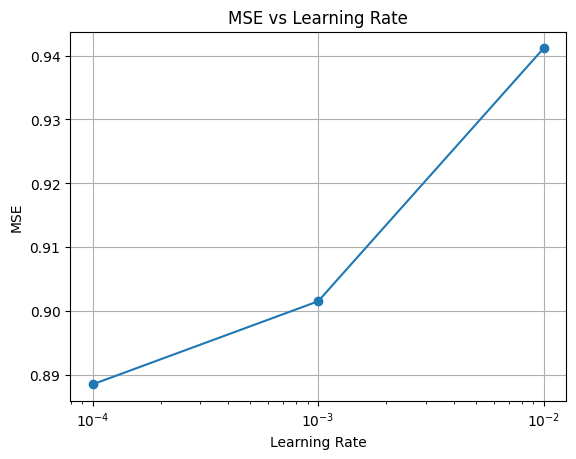

In [ ]:
batch_sizes = [16, 32, 64, 128]
mse_bs = []

for bs in batch_sizes:
    cvae, enc, dec = build_cvae((128, 64), latent_dim=8, learning_rate=0.001)
    cvae.fit(X_train, Y_train, validation_data=(X_val, Y_val),
             epochs=100, batch_size=bs, verbose=0)

    z_mean_test, _, _ = enc.predict(X_test)
    y_pred_scaled = dec.predict(z_mean_test)
    mse_bs.append(mean_squared_error(scaler_Y.inverse_transform(Y_test), scaler_Y.inverse_transform(y_pred_scaled)))

plt.plot(batch_sizes, mse_bs, marker='o')
plt.title("MSE vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

# Learning Rate
lr_list = [0.0001, 0.001, 0.01]
mse_lr = []

for lr in lr_list:
    cvae, enc, dec = build_cvae((128, 64), latent_dim=8, learning_rate=lr)
    cvae.fit(X_train, Y_train, validation_data=(X_val, Y_val),
             epochs=100, batch_size=32, verbose=0)

    z_mean_test, _, _ = enc.predict(X_test)
    y_pred_scaled = dec.predict(z_mean_test)
    mse_lr.append(mean_squared_error(scaler_Y.inverse_transform(Y_test), scaler_Y.inverse_transform(y_pred_scaled)))

plt.plot(lr_list, mse_lr, marker='o')
plt.title("MSE vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("MSE")
plt.xscale("log")
plt.grid(True)
plt.show()


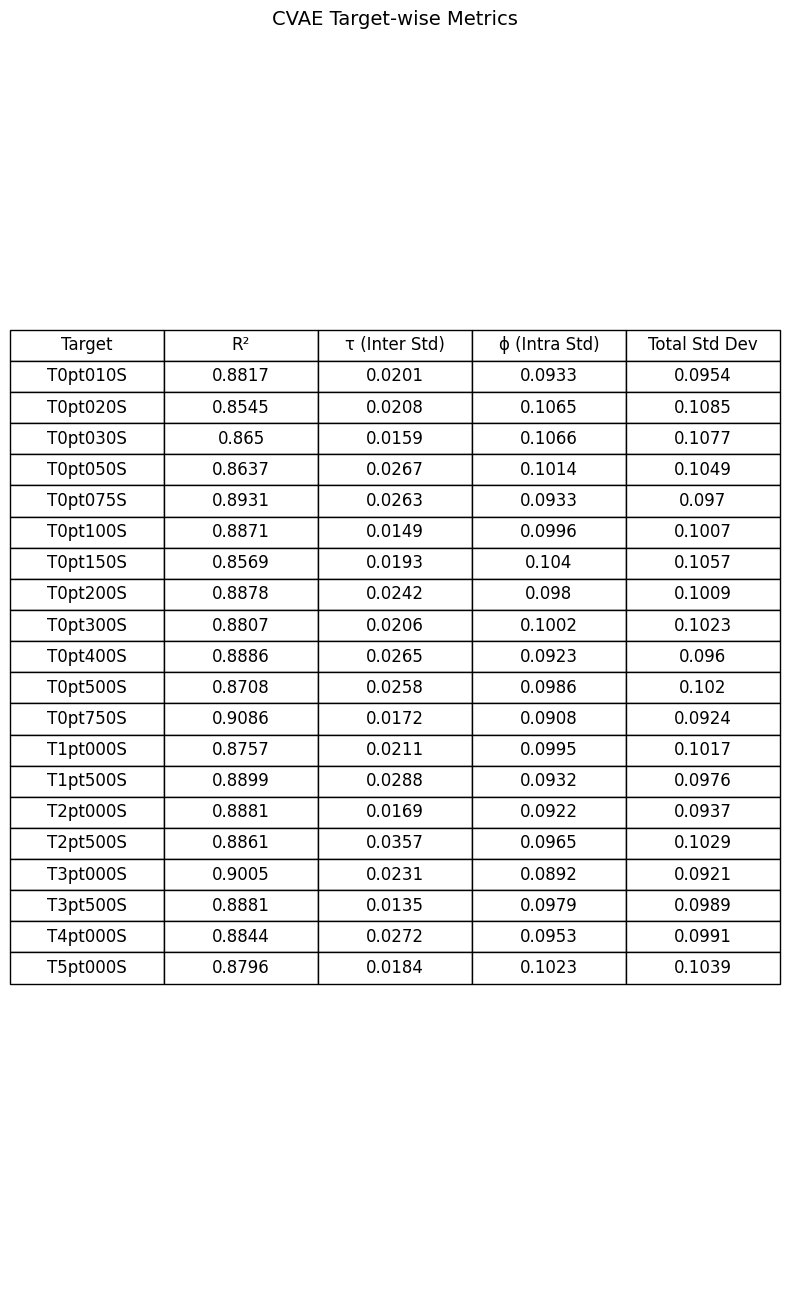

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Replace with your true and predicted values
# Example:
# y_test: numpy array (num_samples, num_targets)
# y_pred: numpy array (num_samples, num_targets)
# target_columns: list of target column names like ['T0pt', 'T1pt', ...]

# Dummy placeholders for this example (replace with actual values)
target_columns = [
    "T0pt010S", "T0pt020S", "T0pt030S", "T0pt050S", "T0pt075S",
    "T0pt100S", "T0pt150S", "T0pt200S", "T0pt300S", "T0pt400S",
    "T0pt500S", "T0pt750S", "T1pt000S", "T1pt500S", "T2pt000S",
    "T2pt500S", "T3pt000S", "T3pt500S", "T4pt000S", "T5pt000S"
]
y_test = np.random.rand(200, len(target_columns))
y_pred = y_test + np.random.normal(0, 0.1, y_test.shape)

# Optional: event_ids for inter/intra event std dev
# event_ids should be a 1D array of length y_test.shape[0] indicating event label
event_ids = np.random.randint(0, 10, size=y_test.shape[0])

# Calculate metrics
results = []
for i, col in enumerate(target_columns):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    residuals = y_test[:, i] - y_pred[:, i]

    # Inter-event std (τ) and Intra-event std (ϕ)
    df = pd.DataFrame({'residuals': residuals, 'event': event_ids})
    inter_event_std = df.groupby('event').mean()['residuals'].std()       # τ
    intra_event_std = df.groupby('event').std()['residuals'].mean()       # ϕ
    total_std = np.sqrt(inter_event_std**2 + intra_event_std**2)

    results.append([col, r2, inter_event_std, intra_event_std, total_std])

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Target', 'R²', 'τ (Inter Std)', 'ϕ (Intra Std)', 'Total Std Dev'])

# Display as table using matplotlib
def plot_table(df):
    fig, ax = plt.subplots(figsize=(8, 0.6 * len(df) + 1))
    ax.axis('off')

    # Convert numeric columns to strings with desired rounding
    numeric_cols = df.columns[1:]  # Exclude the 'Target' column
    df[numeric_cols] = df[numeric_cols].apply(lambda x: pd.Series(np.round(x, 4), index=x.index))

    tbl = ax.table(cellText=df.values,
                   colLabels=df.columns,
                   cellLoc='center',
                   loc='center')
    tbl.scale(1, 1.5)
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    plt.title("CVAE Target-wise Metrics", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_table(results_df)

# Optional: Save as image
# fig.savefig("bnn_metrics_table.png", dpi=300)